In [1]:
import duckdb
import pandas as pd

# Conectando em modo read_only para não travar os outros notebooks
conn = duckdb.connect('medalhao.duckdb', read_only=True)

# Carregando a Gold para o Pandas para facilitar gráficos
df_performance = conn.execute("SELECT * FROM gold.performance_planos").df()

In [2]:
# Carregando a Gold para o Pandas
df_performance = conn.execute("SELECT * FROM gold.performance_planos").df()
df_performance

,tipo_plano,status,total_clientes,faturamento_total,ticket_medio,data_extracao
0,MENSAL,Pendente,72,10094.33,140.20,2026-02-06
1,TRIMESTRAL,Ativo,63,9192.88,145.92,2026-02-06
2,MENSAL,Ativo,61,9084.23,148.92,2026-02-06
3,TRIMESTRAL,Inativo,62,8908.17,143.68,2026-02-06
4,ANUAL,Pendente,57,8239.88,144.56,2026-02-06
5,TRIMESTRAL,Pendente,49,7336.54,149.73,2026-02-06
6,MENSAL,Inativo,51,7097.23,139.16,2026-02-06
7,ANUAL,Inativo,47,6771.94,144.08,2026-02-06
8,ANUAL,Ativo,38,5651.67,148.73,2026-02-06


In [4]:
# Ver estrutura
conn.execute("DESCRIBE bronze.clientes").df()

,column_name,column_type,null,key,default,extra
0,id_cliente,BIGINT,YES,None,None,None
1,nome,VARCHAR,YES,None,None,None
2,email,VARCHAR,YES,None,None,None
3,data_nascimento,DATE,YES,None,None,None
4,plano,VARCHAR,YES,None,None,None
5,status,VARCHAR,YES,None,None,None
6,data_adesao,DATE,YES,None,None,None
7,valor_mensalidade,DOUBLE,YES,None,None,None


In [5]:
# Vamos ver as estatísticas dos clientes
conn.execute("SELECT * FROM bronze.clientes").df().describe()

,id_cliente,data_nascimento,data_adesao,valor_mensalidade
count,500.000000,500,500,500.000000
mean,250.500000,1981-10-15 01:00:28.800000,2025-02-11 07:52:19.200000,144.753740
min,1.000000,1955-03-20 00:00:00,2024-02-10 00:00:00,90.100000
25%,125.750000,1966-02-06 12:00:00,2024-08-04 18:00:00,117.220000
50%,250.500000,1982-07-12 12:00:00,2025-02-07 00:00:00,144.410000
75%,375.250000,1996-03-24 06:00:00,2025-08-23 06:00:00,172.395000
max,500.000000,2008-01-19 00:00:00,2026-02-04 00:00:00,199.850000
std,144.481833,NaN,NaN,31.950225


In [6]:
# 3. Qual o plano mais lucrativo?
plano_top = df_performance.groupby('tipo_plano')['faturamento_total'].sum().idxmax()
print(f"\nO plano com maior faturamento total é o: {plano_top}")


O plano com maior faturamento total é o: MENSAL


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configurando o estilo dos gráficos
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 6))

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

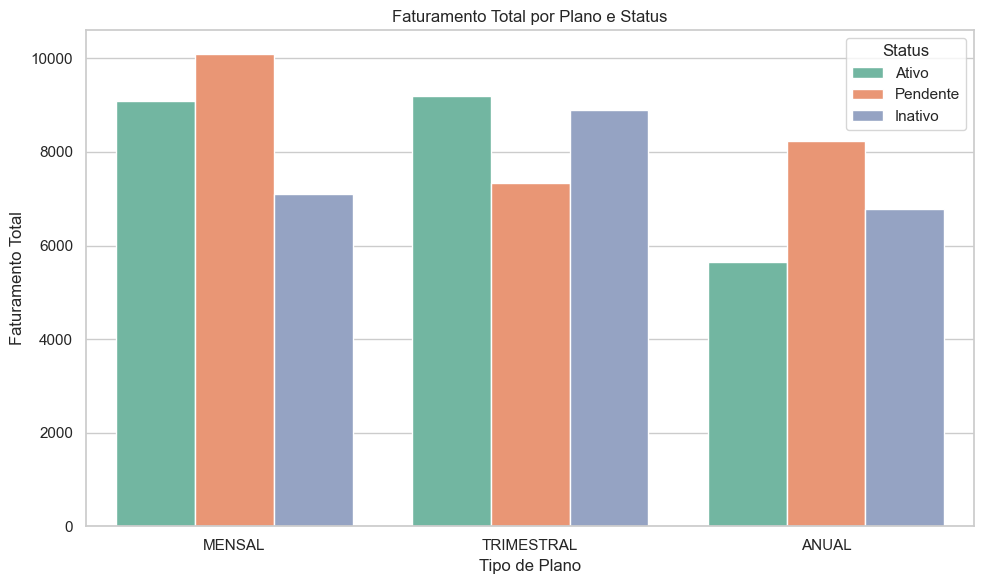

In [13]:
plt.figure(figsize=(10,6))

sns.barplot(
    data=df_performance,
    x='tipo_plano',
    y='faturamento_total',
    hue='status',
    hue_order=['Ativo', 'Pendente', 'Inativo'],
    palette='Set2'
)

plt.title('Faturamento Total por Plano e Status')
plt.xlabel('Tipo de Plano')
plt.ylabel('Faturamento Total')
plt.xticks(rotation=0)
plt.legend(title='Status')

plt.tight_layout()
plt.show()

C:\Users\amand\AppData\Local\Temp\ipykernel_218884\3826772405.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_performance, x='tipo_plano', y='total_clientes', palette='viridis')


([0, 1, 2],
 [Text(0, 0, 'MENSAL'), Text(1, 0, 'TRIMESTRAL'), Text(2, 0, 'ANUAL')])

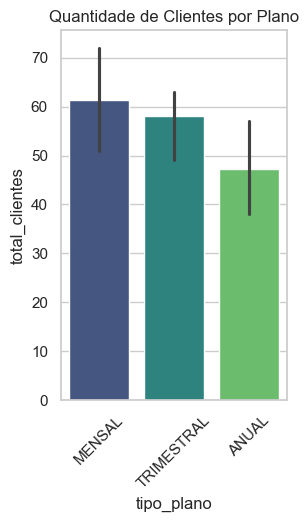

In [9]:
# Gráfico 2: Distribuição de Clientes por Plano
plt.subplot(1, 2, 2)
sns.barplot(data=df_performance, x='tipo_plano', y='total_clientes', palette='viridis')
plt.title('Quantidade de Clientes por Plano')
plt.xticks(rotation=45)

In [4]:
# Apenas executa a consulta e retorna o resultado
resultado = conn.execute("""
    SELECT 
        CASE 
            WHEN date_diff('year', data_nascimento, CURRENT_DATE) < 18 THEN 'Sub-18'
            WHEN date_diff('year', data_nascimento, CURRENT_DATE) BETWEEN 18 AND 30 THEN '18-30'
            WHEN date_diff('year', data_nascimento, CURRENT_DATE) BETWEEN 31 AND 50 THEN '31-50'
            ELSE '51+' 
        END AS faixa_etaria,
        COUNT(*) AS total_alunos,
        ROUND(AVG(valor_mensalidade), 2) AS ticket_medio
    FROM silver.clientes
    GROUP BY faixa_etaria
""").df() # O .df() converte direto para um DataFrame do Pandas

print(resultado)

  faixa_etaria  total_alunos  ticket_medio
0        18-30           129        141.28
1          51+           200        148.19
2        31-50           171        143.36


C:\Users\amand\AppData\Local\Temp\ipykernel_225592\2547692828.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df_analise, x='faixa_etaria', y='total_alunos', palette='viridis')


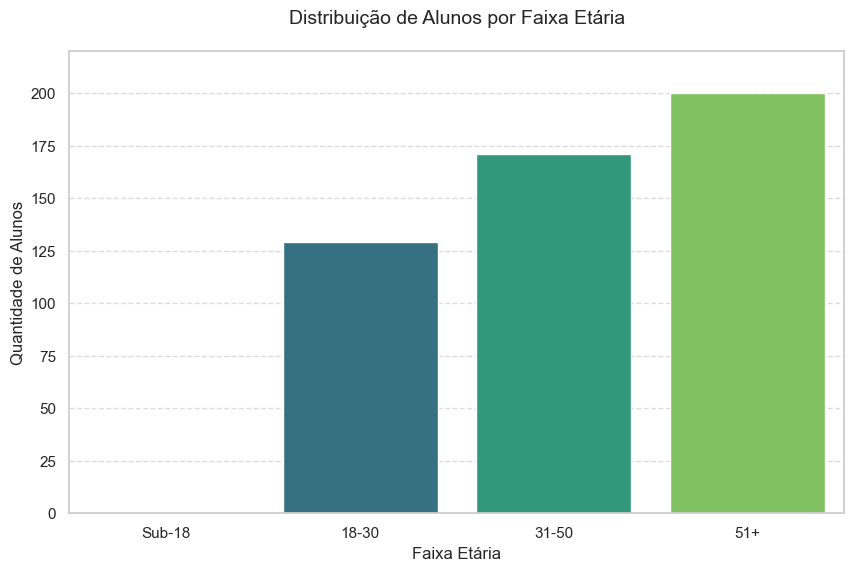

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Garante a ordenação correta
ordem = ['Sub-18', '18-30', '31-50', '51+']
resultado['faixa_etaria'] = pd.Categorical(resultado['faixa_etaria'], categories=ordem, ordered=True)
df_analise = resultado.sort_values('faixa_etaria').reset_index(drop=True)

# 2. Configuração do gráfico
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=df_analise, x='faixa_etaria', y='total_alunos', palette='viridis')

# 3. Adicionando os rótulos de forma automática e centralizada
ax.bar_label(ax.containers[0], padding=3, fontweight='bold')

# Estilização final
plt.title('Distribuição de Alunos por Faixa Etária', fontsize=14, pad=20)
plt.xlabel('Faixa Etária')
plt.ylabel('Quantidade de Alunos')
plt.ylim(0, df_analise['total_alunos'].max() * 1.1) # Dá um respiro no topo
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [6]:
# Verificando faturamento por ano de adesão
df_adesao = conn.execute("""
    SELECT 
        date_part('year', data_adesao) as ano_adesao,
        tipo_plano,
        SUM(valor_mensalidade) as receita_total
    FROM silver.clientes
    GROUP BY ALL
    ORDER BY ano_adesao DESC
""").df()

print(df_adesao)

   ano_adesao  tipo_plano  receita_total
0        2026      MENSAL        2067.02
1        2026  TRIMESTRAL        1124.56
2        2026       ANUAL         790.99
3        2025      MENSAL       13211.76
4        2025  TRIMESTRAL       12465.25
5        2025       ANUAL        9727.73
6        2024      MENSAL       10997.01
7        2024  TRIMESTRAL       11847.78
8        2024       ANUAL       10144.77


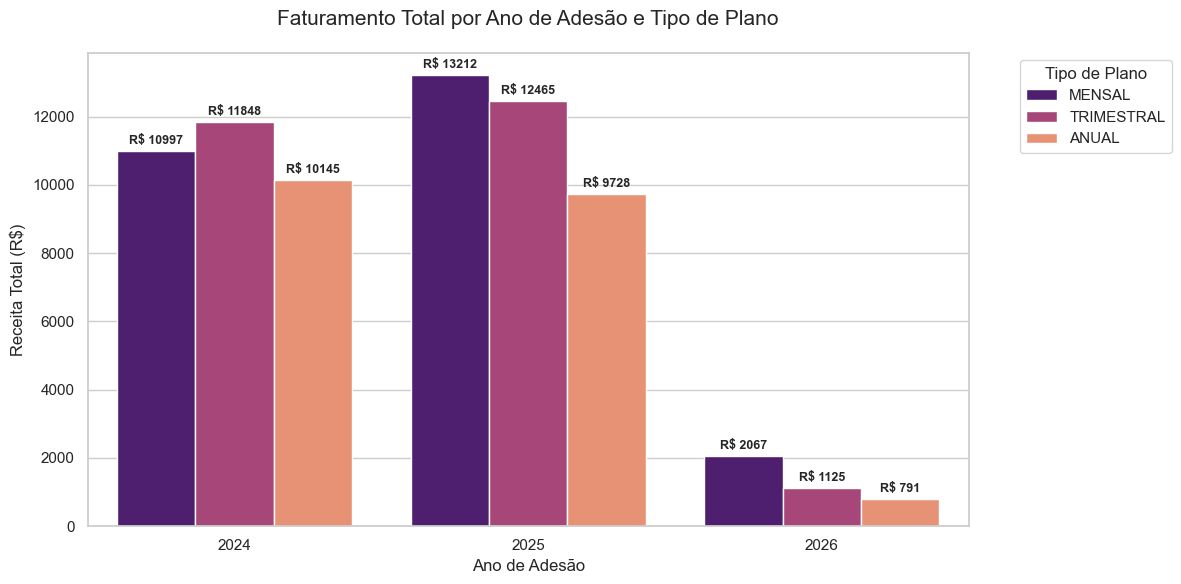

In [12]:
# 2. Criando o gráfico de barras agrupadas
# x = ano, y = receita, hue = diferencia os planos por cor
ax = sns.barplot(
    data=df_adesao, 
    x='ano_adesao', 
    y='receita_total', 
    hue='tipo_plano', 
    palette='magma'
)

# 3. Customização de labels e títulos
plt.title('Faturamento Total por Ano de Adesão e Tipo de Plano', fontsize=15, pad=20)
plt.xlabel('Ano de Adesão', fontsize=12)
plt.ylabel('Receita Total (R$)', fontsize=12)
plt.legend(title='Tipo de Plano', bbox_to_anchor=(1.05, 1), loc='upper left')

# 4. Adicionando os valores em cima das barras
for container in ax.containers:
    ax.bar_label(container, fmt='R$ %.0f', padding=3, fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()